In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import ode
from scipy.linalg import toeplitz

In [2]:
class Parameters(object):
    def __init__(self):
        pass

In [3]:
def KuramotoSakaguchi(t, y0, prms):
    '''Eq.(1) of "Chimera states are chaotic transients"
    10.1103/PhysRevE.84.015201
    Parameters: 
    N=40, R=14, alpha=1.46
    '''
    f = y0.copy()
    psi = y0[0:prms.N]
    sum_neighbors = 1/(2*prms.R)*np.sum( np.sin(prms.adj_matrix*(psi[:,None] - psi[None,:]) + prms.alpha), axis=1 )
    f[0:prms.N] = prms.omega - sum_neighbors
    return f

In [4]:
def E_ring_neighbors_symmetric(R, N):
    assert N > 1
    assert R > 0
    assert R <= N-1
    if 2*R >= N-1:
        EE = np.ones((N,N))-np.eye(N)
    else:
        row_or_col = np.zeros((1,N))
        row_or_col[0][ np.array([i for i in list(range(1,R+1)) + list(range(N-R,N))]) ] = 1
        EE = toeplitz(row_or_col, row_or_col)
    return EE

In [5]:
parameters = Parameters()

parameters.N = 40#6
parameters.R = 14#2
parameters.alpha = 1.46

In [6]:
parameters.omega = np.zeros(parameters.N)

In [7]:
E = E_ring_neighbors_symmetric(parameters.R, parameters.N)
parameters.adj_matrix = E
parameters.adj_matrix

array([[0., 1., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 1., 0.]])

In [8]:
def gaussian_pi(mu, sigma, xx):
    return np.pi*np.exp(-(xx-mu)**2/(2*sigma**2))

def gaussian_envelope(mu, sigma, xx):
    env_list = []
    for x in xx:
        xxx = np.random.uniform(-gaussian_pi(mu, sigma, x), gaussian_pi(mu, sigma, x))
        env_list.append(xxx)
    return np.array(env_list)

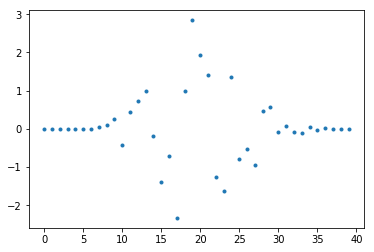

In [9]:
mu_0 = parameters.N/2
sigma_0 = parameters.N/8
xx_0 = np.arange(parameters.N)

z0 = gaussian_envelope(mu_0, sigma_0, xx_0)

plt.plot(z0, '.')
plt.show()

In [10]:
t0 = 0.0
tmax = 100
dt = 0.01
solver = ode(KuramotoSakaguchi).set_f_params(parameters)

solver.set_integrator('dopri5')
solver.set_initial_value(z0, t0)

In [11]:
%%time
sol = [z0] 
while solver.successful() and solver.t <= tmax:
    solver.integrate(solver.t+dt)
    sol.append(solver.y) 
print('Integration finished for {} time'.format(tmax/dt))
thetas = np.array(sol)

Integration finished for 10000.0 time
CPU times: user 4.88 s, sys: 0 ns, total: 4.88 s
Wall time: 4.91 s


In [12]:
thetas.shape

(10001, 40)

In [13]:
def radians(degrees):
    return (degrees/(2*np.pi) - degrees//(2*np.pi)) * (2*np.pi)

radians(thetas).shape

(10001, 40)

In [14]:
def order_parameter(theta):
    if theta.ndim == 1:
        z = sum(np.exp(theta*1j))/len(theta)
        return np.array([np.absolute(z), np.angle(z)])
    elif theta.ndim == 2:
        return np.array([order_parameter(theta[i]) for i in range(np.shape(theta)[0])]).T
    raise Exception('error')
    
r, psi = order_parameter(thetas)
r.shape

(10001,)

In [18]:
dth = np.diff(thetas, axis=0)/dt
zs = np.zeros((1, dth.shape[1]))
frequencies = np.concatenate((zs, dth), axis=0)
frequencies.shape

(10001, 40)

In [20]:
c = np.cumsum(frequencies.T, axis=1)
d = np.arange((frequencies.T).shape[1])+1
time_averaged_frequencies = (c/d).T
time_averaged_frequencies.shape

(10001, 40)

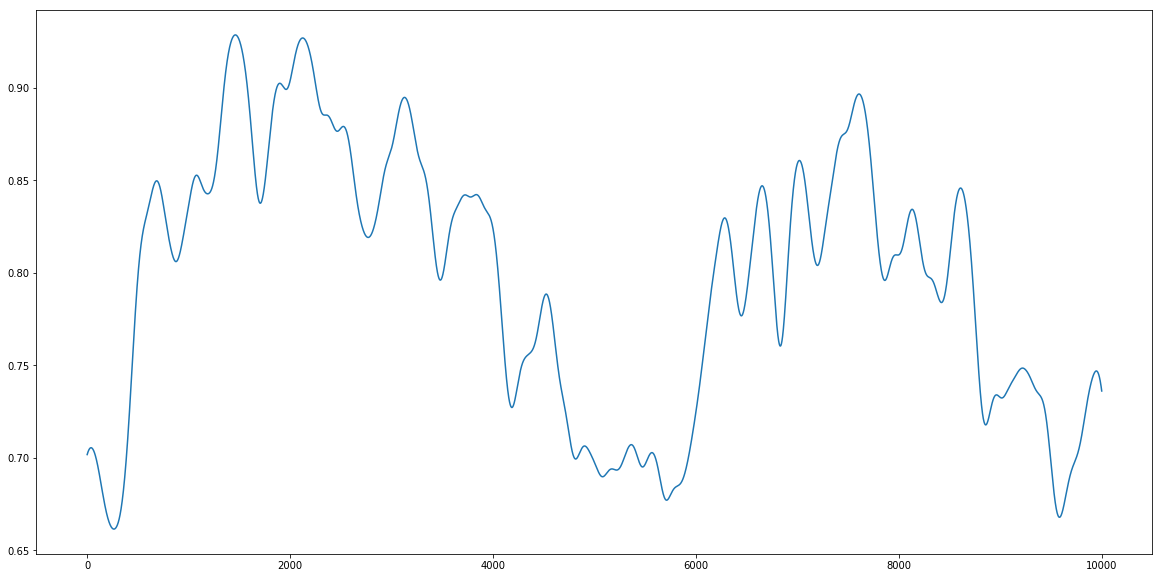

In [15]:
plt.figure(figsize=(20,10))
plt.plot(r)#[3000:5000])
plt.show()

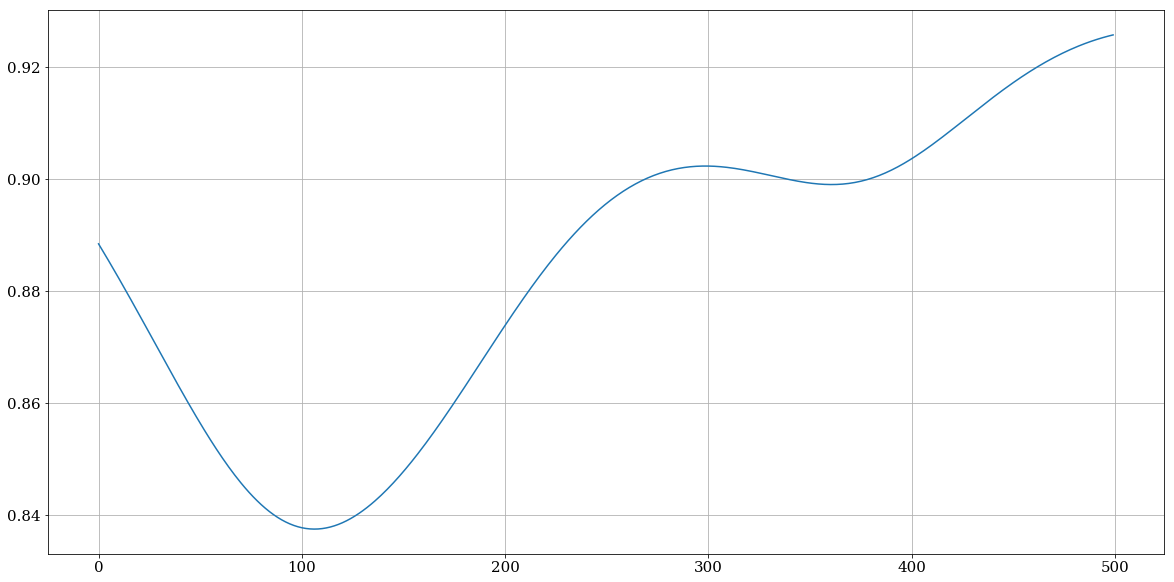

In [29]:
plt.figure(figsize=(20,10))
plt.plot(r[1600:2100])
plt.grid(True)
plt.show()

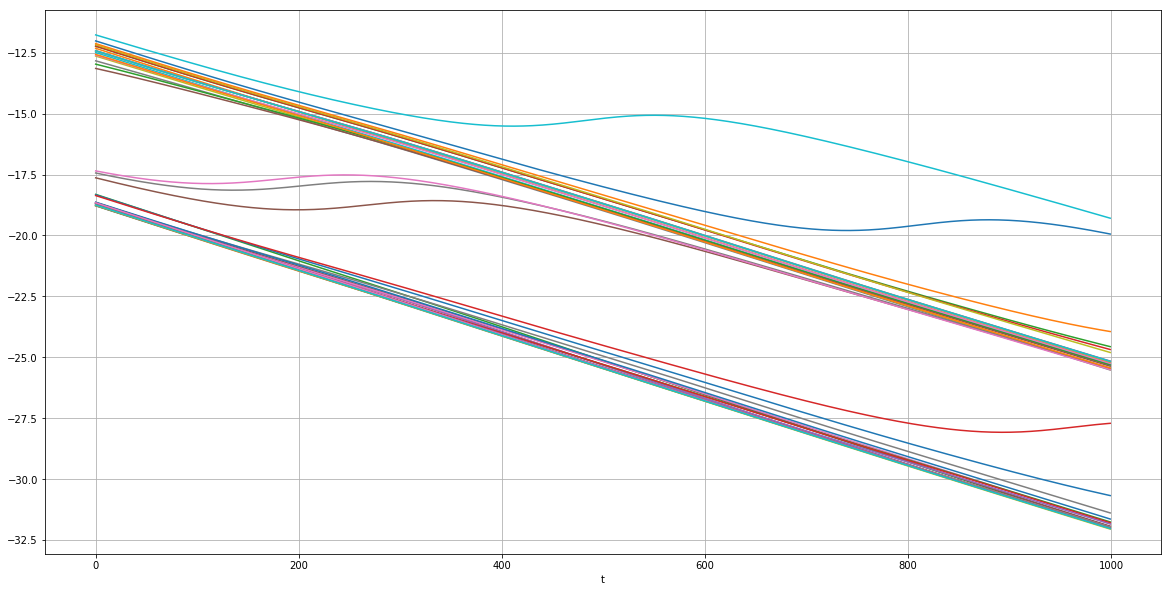

In [17]:
plt.figure(figsize=(20,10))
for th in range(len(z0)):
    plt.plot(thetas[:,th][1500:2500])
plt.xlabel('t')
plt.grid(True)
plt.show()

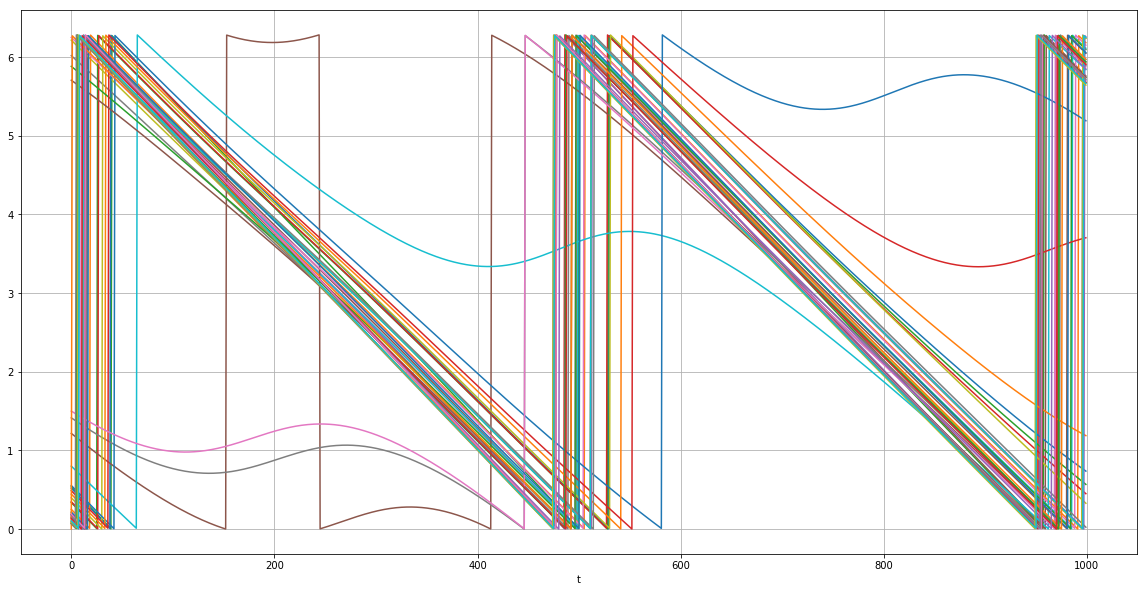

In [21]:
plt.figure(figsize=(20,10))
for th in range(len(z0)):
    plt.plot(radians(thetas[:,th])[1500:2500])
plt.xlabel('t')
plt.grid(True)
plt.show()

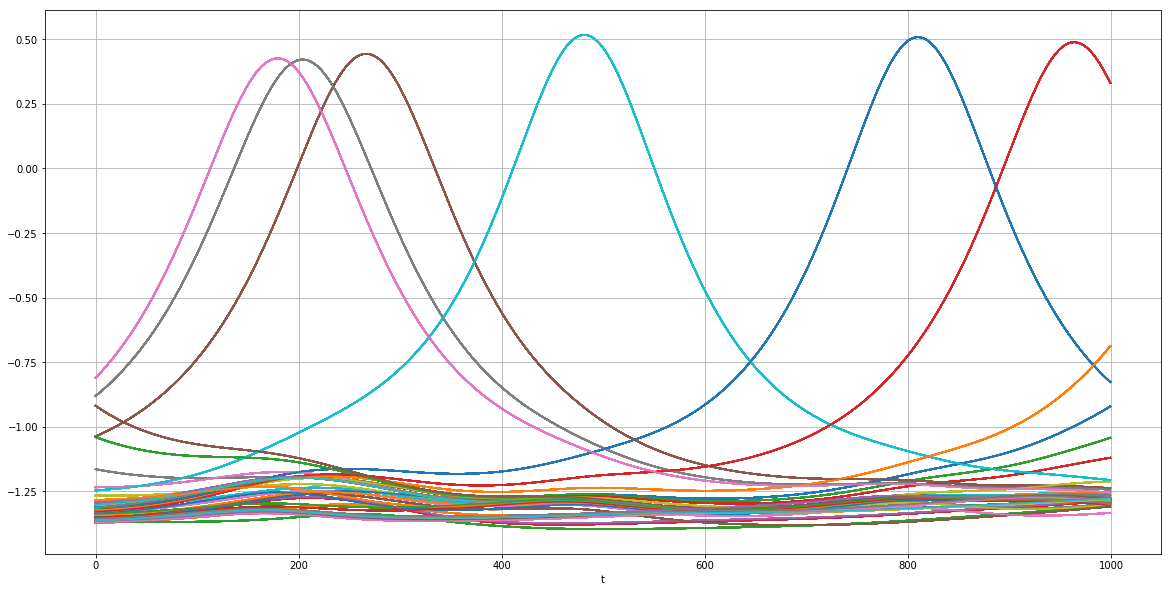

In [22]:
plt.figure(figsize=(20,10))
for th in range(len(z0)):
    plt.plot(frequencies[1500:2500])
plt.xlabel('t')
plt.grid(True)
plt.show()

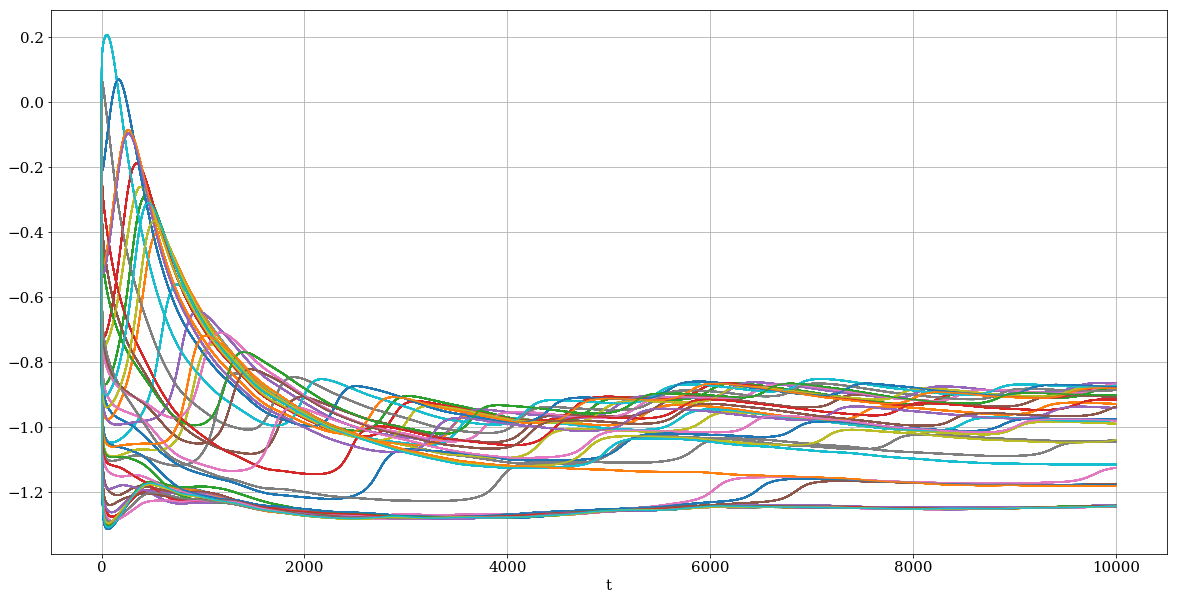

In [30]:
plt.figure(figsize=(20,10))
for th in range(len(z0)):
    plt.plot(time_averaged_frequencies)#[1500:2500])
plt.xlabel('t')
plt.grid(True)
plt.show()

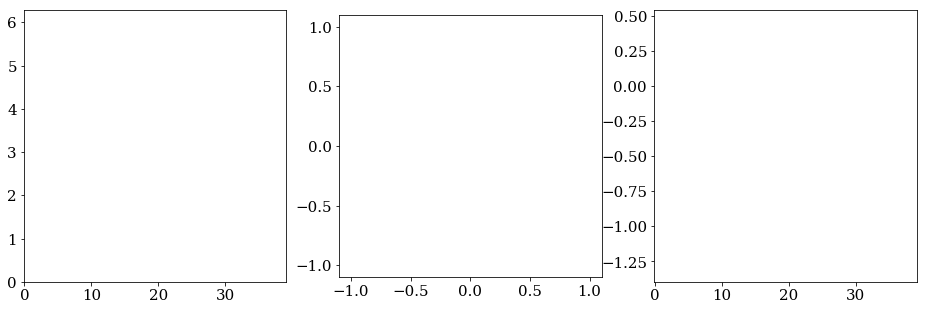

In [24]:
import matplotlib as mpl
from matplotlib import animation

#set general plot options
font = {'family': 'serif', 'weight': 'normal', 'size': 15}
mpl.rc('font', **font)
mpl.rcParams['mathtext.fontset'] = 'cm'

fig = plt.figure(figsize=(16,5))

ax1 = fig.add_subplot(131)
ax1.set_xlim(( -0.1, thetas.shape[1]-0.9))
ax1.set_ylim(( 0, 2*np.pi))

ax2 = fig.add_subplot(132)
ax2.set_xlim([-1.1, 1.1])
ax2.set_ylim([-1.1, 1.1])
ax2.set_aspect('equal')

ax3 = fig.add_subplot(133)
ax3.set_xlim(( -0.1, thetas.shape[1]-0.9))
ax3.set_ylim(( np.min(frequencies), np.max(frequencies) ))

line_1 = ax1.scatter([], [], marker='.')
line_2 = ax2.scatter([], [], marker='.', color='r')
line_2a = ax2.scatter([], [], marker='.')
line_3 = ax3.scatter([], [], marker='.')
time_text_1 = ax1.text(0.02, 0.95, '', transform=ax1.transAxes)
r_text = ax2.text(0.02, 0.95, '', transform=ax2.transAxes)
time_text_3 = ax3.text(0.02, 0.95, '', transform=ax3.transAxes)

In [ ]:
if

In [27]:
%%time

fraction = 0.05
t_start = 9500

def init():
    clr = np.arange(thetas.shape[1])
    line_1.set_offsets([])
    line_1.set_array(clr)
    line_2.set_offsets([])
    line_2a.set_offsets([])
    line_2a.set_array(clr)
    line_3.set_offsets([])
    line_3.set_array(clr)
    time_text_1.set_text('')
    r_text.set_text('')
    time_text_3.set_text('')
    return line_1, line_2, line_2a, line_3, time_text_1, r_text, time_text_3,

def animate(i):
    x = np.arange(thetas.shape[1])
    z = radians(thetas)[i+t_start]
    y = z[x]
    u = r[i+t_start]
    v = psi[i+t_start]
    ww = time_averaged_frequencies[i+t_start]#np.mean(frequencies[0:i+t_start+1], axis=0)
    w = ww[x]
    line_1.set_offsets(np.transpose([x,y]))#, c=clr)
    line_2.set_offsets(np.array([u*np.cos(v), u*np.sin(v)]))
    line_2a.set_offsets(np.transpose([np.cos(z), np.sin(z)]))
    line_3.set_offsets(np.transpose([x,w]))
    time_text_1.set_text('time = {0:0d}'.format(i+t_start))
    r_text.set_text('r = {0:.2f}'.format(r[i+t_start]))
    time_text_3.set_text('time = {0:0d}'.format(i+t_start))
    return line_1, line_2, line_2a, line_3, time_text_1, r_text, time_text_3,

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=int(thetas.shape[0]*fraction), interval=10, blit=False)

anim.save('scratch_06_z' + '.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
plt.close(fig)

CPU times: user 3min 40s, sys: 11 s, total: 3min 51s
Wall time: 58.2 s
